In [1]:
#!/usr/bin/env python

# heatwave_an-maxlen_plots.ipynb

'''
    File name: conditions_WBGT_monthmax.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 04.30.2024
    Date last modified: 04.30.2024

    ############################################################## 
    Needs data from:
    papers/2024/2024_WBGT_Climate-Change/programs/heatwave_maxlen-map/heatwave_an-maxlen.ipynb
    
    
    Purpose:

    1) Read annual heatwave frequency and maximum length and store data for future processing
    2) Plot maps for different warming targets showing changes in frequency and duration
    

'''

In [2]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
import pickle
import time
import xarray as xr
from tqdm import tqdm
import matplotlib.gridspec as gridspec
import random

import warnings
warnings.filterwarnings("ignore")

In [3]:
def solar_time_difference_from_utc(longitude):
    from datetime import datetime, timedelta, timezone
    """
    Calculate the difference between local solar time and UTC based on the given longitude.

    Args:
    - longitude (float): The longitude of the location in degrees (East is positive, West is negative).

    Returns:
    - time_difference (timedelta): The difference from UTC as a timedelta object.
    """
    # Calculate the time difference due to longitude (in minutes)
    time_difference_minutes = longitude * 4  # 4 minutes per degree

    # Create a timedelta object for the time difference
    time_difference = timedelta(minutes=time_difference_minutes)
    
    return time_difference

### User imput section

In [4]:
data_dir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/GWBT/'
save_dir_base = '/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/heatwaves/'

simulation = "ctr"

time_c404_ctr = pd.date_range(datetime.datetime(1980, 1, 1, 0), 
                              end=datetime.datetime(2021, 12, 31, 23), freq='h')
years_ctr = np.unique(time_c404_ctr.year)
conus404_pgw_dir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData_PGW/GWBT/'
time_c404_pgw = pd.date_range(datetime.datetime(1980, 1, 1, 0), 
                              end=datetime.datetime(2021, 12, 31, 23), freq='h')
years_pgw = np.unique(time_c404_pgw.year)

In [5]:
temp_channge = np.arange(0,3.1,0.1)
delta_t = 0.25
minyears = 7

### Load global average LENS2 temperature for warming level selection

In [6]:
data = pd.read_csv('/glade/u/home/prein/papers/2024/2024_WBGT_Climate-Change/data/NASA_global-av_t2m/graph.txt', delimiter=r"\s+", header=0, skiprows=[0,1,2,4])

StartDay = datetime.datetime(1850, 1, 15,1)
StopDay = datetime.datetime(2101, 1, 15,0)
Time=pd.date_range(StartDay, end=StopDay, freq='M')
Time_years=pd.date_range(StartDay, end=StopDay, freq='Y')
years = np.unique(Time.year)

reference_period = [1950, 1980]

lens2_t2m_dir = '/glade/campaign/mmm/c3we/mingge/DOD/LENS2/'
ncid=Dataset(lens2_t2m_dir + 'TREFMNAV_monthly_globalAvg_185001-197912.nc', mode='r')
TREFMNAV_hist = np.array(np.squeeze(ncid.variables['TREFMNAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMNAV_monthly_globalAvg_198001-201412.nc', mode='r')
TREFMNAV_cur = np.array(np.squeeze(ncid.variables['TREFMNAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMNAV_monthly_globalAvg_201501-210012.nc', mode='r')
TREFMNAV_fut = np.array(np.squeeze(ncid.variables['TREFMNAV'][:]))
ncid.close()

ncid=Dataset(lens2_t2m_dir + 'TREFMXAV_monthly_globalAvg_185001-197912.nc', mode='r')
TREFMXAV_hist = np.array(np.squeeze(ncid.variables['TREFMXAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMXAV_monthly_globalAvg_198001-201412.nc', mode='r')
TREFMXAV_cur = np.array(np.squeeze(ncid.variables['TREFMXAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMXAV_monthly_globalAvg_201501-210012.nc', mode='r')
TREFMXAV_fut = np.array(np.squeeze(ncid.variables['TREFMXAV'][:]))
ncid.close()

TREFMNAV = np.append(TREFMNAV_hist, TREFMNAV_cur, axis=1)
TREFMNAV = np.append(TREFMNAV, TREFMNAV_fut, axis=1)
TREFMXAV = np.append(TREFMXAV_hist, TREFMXAV_cur, axis=1)
TREFMXAV = np.append(TREFMXAV, TREFMXAV_fut, axis=1)
lens2_t2m = (TREFMNAV + TREFMXAV) / 2.

lens2_t2m_y = np.mean(np.reshape(lens2_t2m, (lens2_t2m.shape[0], int(lens2_t2m.shape[1]/12), 12)), axis=2)

ref_t2m = np.mean(lens2_t2m_y[:,(years >= reference_period[0]) & (years <= reference_period[1])])
time_to_t2m = np.mean(lens2_t2m_y, axis=0) - ref_t2m

dc_hist = np.arange(0,1.5,0.1)
dc_pgw = np.arange(0,3.5,0.1)
dc = 0.25 # deg. C

ref_period = [1950,1979]

era5_ref = np.mean(data['No_Smoothing'][(data['Year'] >= ref_period[0]) & (data['Year'] <= ref_period[1])])
era5_warming = np.squeeze(np.array([data['No_Smoothing'][data['Year'] == yy] - era5_ref for yy in range(1980,2022,1)]))

lens2_ref = np.mean(time_to_t2m[(years >= ref_period[0]) & (years <= ref_period[1])])
lens2_warming = np.array([time_to_t2m[years == yy][0] - lens2_ref for yy in range(2022,2022+len(np.unique(time_c404_pgw.year)),1)])

pgw_warming = np.zeros((len(years_ctr))); pgw_warming[:] = np.nan
for yy in range(len(years_ctr)):
    lens_hist = (years <= years_ctr[yy] + 5) & (years >= years_ctr[yy] - 5)
    lens_fut = (years <= years_ctr[yy] + 40 + 5) & (years >= years_ctr[yy] + 40 - 5)
    pgw_warming[yy] = data['No_Smoothing'][years_ctr[yy] == data['Year']] + np.mean(time_to_t2m[lens_fut]) - np.mean(time_to_t2m[lens_hist])

In [7]:
warming_tar = 0.25
targ_ref = years_ctr[(era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)]

warming_tar = 1
targ_1C = years_ctr[(era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)]

warming_tar = 2
targ_2C = years_pgw[(pgw_warming[:len(years_pgw)] >= warming_tar - dc) & (pgw_warming[:len(years_pgw)] <= warming_tar + dc)]

# Read CONUS404 CTR OR PGW WBGT DATA

In [8]:
# read CONUS404 coordinates
ncid=Dataset('/glade/campaign/ncar/USGS_Water/CONUS404/wrfconstants_d01_1979-10-01_00:00:00.nc4', mode='r')
lon_conus = np.array(np.squeeze(ncid.variables['XLONG'][:]))
lat_conus = np.array(np.squeeze(ncid.variables['XLAT'][:]))
ncid.close()

In [9]:
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.feature as cf
import cartopy.crs as ccrs
GEO_EM_D1 = '/glade/u/home/prein/projects/2020/2020_CONUS404/programs/plots/Domain/geo_em.d01.nc'
ncfile = Dataset(GEO_EM_D1)
HGT_M = getvar(ncfile, "HGT_M")
LU = getvar(ncfile, "LU_INDEX")
cart_proj = get_cartopy(HGT_M)
ncid.close()



### Load preprocessed data

In [10]:
frequency_ctr = np.zeros((len(years_ctr), lon_conus.shape[0], lon_conus.shape[1])); frequency_ctr[:] = np.nan
maxlen_ctr = np.copy(frequency_ctr)

frequency_pgw = np.zeros((len(years_pgw), lon_conus.shape[0], lon_conus.shape[1])); frequency_pgw[:] = np.nan
maxlen_pgw = np.copy(frequency_pgw)

for yy in tqdm(range(len(years_ctr))):
    save_file = save_dir_base + "/ctr_" + str(years_ctr[yy]) + "_heatwave-stats_v2.nc"
    ds = xr.open_dataset(save_file)
    frequency_ctr[yy,:,:] = ds["frequency"]
    maxlen_ctr[yy,:,:] = ds["longest_period"]

    save_file = save_dir_base + "/pgw_" + str(years_pgw[yy]) + "_heatwave-stats_v2.nc"
    ds = xr.open_dataset(save_file)
    frequency_pgw[yy,:,:] = ds["frequency"]
    maxlen_pgw[yy,:,:] = ds["longest_period"]

 98%|█████████▊| 41/42 [00:13<00:00,  3.01it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/heatwaves/pgw_2021_heatwave-stats_v2.nc'

In [11]:
def coarsen(data,
            factor):
    data = np.reshape(data[:int(int(data.shape[0]/factor)*factor),
                           :int(int(data.shape[1]/factor)*factor)], 
                             (int(data.shape[0]/factor),
                             factor,
                             int(data.shape[1]/factor),
                             factor))
    return np.mean(data, axis = (1,3))

def coarsen3d(data,
            factor):
    data = np.reshape(data[:,:int(int(data.shape[1]/factor)*factor),
                             :int(int(data.shape[2]/factor)*factor)], 
                             (data.shape[0],
                              int(data.shape[1]/factor),
                             factor,
                             int(data.shape[2]/factor),
                             factor))
    return np.mean(data, axis = (2,4))
gc = 5

mkdir: cannot create directory ‘’: No such file or directory


        Plot map to: heatwave_statistics.jpg


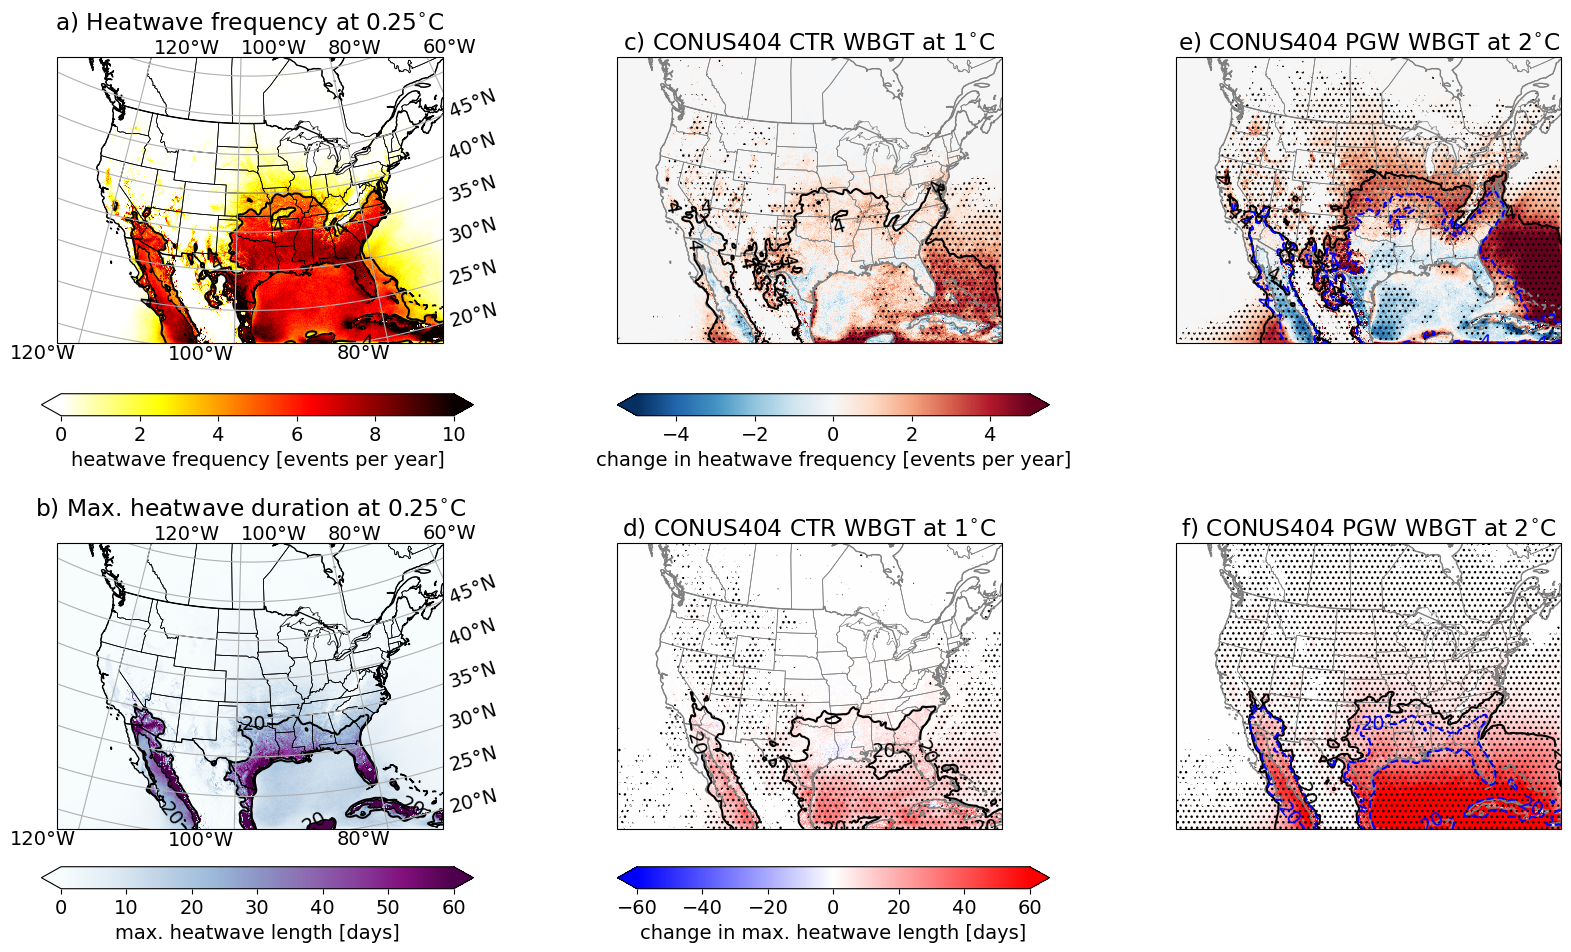

In [19]:
fig = plt.figure(figsize=(16,11))
plt.rcParams.update({'font.size': 14})
gs1 = gridspec.GridSpec(2,3)
gs1.update(left=0.05, right=0.99,
           bottom=0.12, top=0.93,
           wspace=0.45, hspace=0.2)

freq_max = 10

# =========================
# 0.25 C warming frequency
ax = plt.subplot(gs1[0,0], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 0.25
targ_years_ref = (era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)
plt.title('a) Heatwave frequency at '+str(warming_tar)+'$^{\circ}$C')

cs = ax.pcolormesh(lon_conus, lat_conus, np.nanmean(frequency_ctr[targ_years_ref,:], axis=0), 
                   cmap="hot_r", 
                   transform=ccrs.PlateCarree(),
                   vmin=0,
                   vmax=freq_max)

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.STATES, lw=0.5)
# if foc_region == 'Yuma':
#    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.left_labels = False
gl.xlabel_style = {'rotation': 0}

CS = plt.contour(lon_conus, lat_conus,
                   scipy.ndimage.gaussian_filter(np.nanmean(frequency_ctr[targ_years_ref,:], axis=0), 5),
                   levels = [4], transform=ccrs.PlateCarree(), colors='black')
ax.clabel(CS, inline=1, fontsize=14)

# Add a color bar
CbarAx = plt.axes([0.04, 0.55, 0.27, 0.02])
cb = plt.colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
cb.set_label('heatwave frequency [events per year]', fontsize=14)


# =========================
# 1 C frequency change
ax = plt.subplot(gs1[0,1], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 1
targ_years = (era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)
plt.title('c) CONUS404 CTR WBGT at '+str(warming_tar)+'$^{\circ}$C')

change_signal = np.nanmean(frequency_ctr[targ_years,:], axis=0) - \
                   np.nanmean(frequency_ctr[targ_years_ref,:], axis=0)
cs = ax.pcolormesh(lon_conus, lat_conus, 
                   change_signal, 
                   cmap='RdBu_r', vmin=-freq_max/2,vmax=freq_max/2, transform=ccrs.PlateCarree())

sig = scipy.stats.mannwhitneyu(coarsen3d(frequency_ctr[targ_years,:], gc), 
                             coarsen3d(frequency_ctr[targ_years_ref,:], gc), axis = 0)
# add significance layer
ax.contourf(
    coarsen(lon_conus, gc), coarsen(lat_conus, gc), 
    sig.pvalue < 0.05,
    transform=ccrs.PlateCarree(),
    colors='none',
    levels=[.5,1.5],
    hatches=['...',''],
)

ax.coastlines(color="grey")
ax.add_feature(cf.BORDERS, edgecolor="grey")
ax.add_feature(cf.STATES, lw=0.5, edgecolor="grey")
#if foc_region == 'Yuma':
#    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())

CS = plt.contour(lon_conus, lat_conus,
                   scipy.ndimage.gaussian_filter(np.nanmean(frequency_ctr[targ_years,:], axis=0), 5),
                   levels = [4], transform=ccrs.PlateCarree(), colors='black')
ax.clabel(CS, inline=1, fontsize=14)

# Add a color bar
CbarAx = plt.axes([0.4, 0.55, 0.27, 0.02])
cb = plt.colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
cb.set_label('change in heatwave frequency [events per year]', fontsize=14)


# =========================
# 2 C frequency change
ax = plt.subplot(gs1[0,2], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 2
targ_years = (pgw_warming[:len(years_pgw)] >= warming_tar - dc) & (pgw_warming[:len(years_pgw)] <= warming_tar + dc)
plt.title('e) CONUS404 PGW WBGT at '+str(warming_tar)+'$^{\circ}$C')

change_signal = np.nanmean(frequency_pgw[targ_years,:], axis=0) - \
                   np.nanmean(frequency_ctr[targ_years_ref,:], axis=0)
cs = ax.pcolormesh(lon_conus, lat_conus, 
                   change_signal, 
                   cmap='RdBu_r', vmin=-freq_max/2,vmax=freq_max/2, transform=ccrs.PlateCarree())

sig = scipy.stats.mannwhitneyu(coarsen3d(frequency_pgw[targ_years,:], gc), 
                             coarsen3d(frequency_ctr[targ_years_ref,:], gc), axis = 0)
# add significance layer
ax.contourf(
    coarsen(lon_conus, gc), coarsen(lat_conus, gc), 
    sig.pvalue < 0.05,
    transform=ccrs.PlateCarree(),
    colors='none',
    levels=[.5,1.5],
    hatches=['...',''],
)

CS = plt.contour(lon_conus, lat_conus,
                   scipy.ndimage.gaussian_filter(np.nanmean(frequency_pgw[targ_years,:], axis=0), 5),
                   levels = [4], transform=ccrs.PlateCarree(), colors='black')
ax.clabel(CS, inline=1, fontsize=14)

CS = plt.contour(lon_conus, lat_conus,
                   scipy.ndimage.gaussian_filter(np.nanmean(frequency_ctr[targ_years_ref,:], axis=0), 5),
                   levels = [4], transform=ccrs.PlateCarree(), colors='blue', linestyles="dashed")
ax.clabel(CS, inline=1, fontsize=14)


ax.coastlines(color="grey")
ax.add_feature(cf.BORDERS, edgecolor="grey")
ax.add_feature(cf.STATES, lw=0.5, edgecolor="grey")
#if foc_region == 'Yuma':
#    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())


# ===========================================================================
# ===========================================================================
# ===========================================================================
# 0.25 C warming length
ax = plt.subplot(gs1[1,0], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 0.25
targ_years_ref = (era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)
plt.title('b) Max. heatwave duration at '+str(warming_tar)+'$^{\circ}$C')

cs = ax.pcolormesh(lon_conus, lat_conus, np.nanmean(maxlen_ctr[targ_years_ref,:], axis=0), 
                   cmap="BuPu", 
                   transform=ccrs.PlateCarree(),
                   vmin=0,
                   vmax=60)

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.STATES, lw=0.5)
# if foc_region == 'Yuma':
#    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.left_labels = False
gl.xlabel_style = {'rotation': 0}

CS = plt.contour(lon_conus, lat_conus,
                   scipy.ndimage.gaussian_filter(np.nanmean(maxlen_ctr[targ_years_ref,:], axis=0), 5),
                   levels = [20], transform=ccrs.PlateCarree(), colors='black')
ax.clabel(CS, inline=1, fontsize=14)

# Add a color bar
CbarAx = plt.axes([0.04, 0.12, 0.27, 0.02])
cb = plt.colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
cb.set_label('max. heatwave length [days]', fontsize=14)




# =========================
# 1 C length change
ax = plt.subplot(gs1[1,1], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 1
targ_years = (era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)
plt.title('d) CONUS404 CTR WBGT at '+str(warming_tar)+'$^{\circ}$C')

change_signal = np.nanmean(maxlen_ctr[targ_years,:], axis=0) - \
                   np.nanmean(maxlen_ctr[targ_years_ref,:], axis=0)
cs = ax.pcolormesh(lon_conus, lat_conus, 
                   change_signal, 
                   cmap='bwr', vmin=-60,vmax=60, transform=ccrs.PlateCarree())

sig = scipy.stats.mannwhitneyu(coarsen3d(maxlen_ctr[targ_years,:], gc), 
                             coarsen3d(maxlen_ctr[targ_years_ref,:], gc), axis = 0)
# add significance layer
ax.contourf(
    coarsen(lon_conus, gc), coarsen(lat_conus, gc), 
    sig.pvalue < 0.05,
    transform=ccrs.PlateCarree(),
    colors='none',
    levels=[.5,1.5],
    hatches=['...',''],
)

ax.coastlines(color="grey")
ax.add_feature(cf.BORDERS, edgecolor="grey")
ax.add_feature(cf.STATES, lw=0.5, edgecolor="grey")
#if foc_region == 'Yuma':
#    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())

CS = plt.contour(lon_conus, lat_conus,
                   scipy.ndimage.gaussian_filter(np.nanmean(maxlen_ctr[targ_years,:], axis=0), 5),
                   levels = [20], transform=ccrs.PlateCarree(), colors='black')
ax.clabel(CS, inline=1, fontsize=14)

# Add a color bar
CbarAx = plt.axes([0.4, 0.12, 0.27, 0.02])
cb = plt.colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
cb.set_label('change in max. heatwave length [days]', fontsize=14)





# =========================
# 2 C length change
ax = plt.subplot(gs1[1,2], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 2
targ_years = (pgw_warming[:len(years_pgw)] >= warming_tar - dc) & (pgw_warming[:len(years_pgw)] <= warming_tar + dc)
plt.title('f) CONUS404 PGW WBGT at '+str(warming_tar)+'$^{\circ}$C')

change_signal = np.nanmean(maxlen_pgw[targ_years,:], axis=0) - \
                   np.nanmean(maxlen_ctr[targ_years_ref,:], axis=0)
cs = ax.pcolormesh(lon_conus, lat_conus, 
                   change_signal, 
                   cmap='bwr', vmin=-60,vmax=60, transform=ccrs.PlateCarree())

sig = scipy.stats.mannwhitneyu(coarsen3d(maxlen_pgw[targ_years,:], gc), 
                             coarsen3d(maxlen_ctr[targ_years_ref,:], gc), axis = 0)
# add significance layer
ax.contourf(
    coarsen(lon_conus, gc), coarsen(lat_conus, gc), 
    sig.pvalue < 0.05,
    transform=ccrs.PlateCarree(),
    colors='none',
    levels=[.5,1.5],
    hatches=['...',''],
)

CS = plt.contour(lon_conus, lat_conus,
                   scipy.ndimage.gaussian_filter(np.nanmean(maxlen_pgw[targ_years,:], axis=0), 5),
                   levels = [20], transform=ccrs.PlateCarree(), colors='black')
ax.clabel(CS, inline=1, fontsize=14)

CS = plt.contour(lon_conus, lat_conus,
                   scipy.ndimage.gaussian_filter(np.nanmean(maxlen_ctr[targ_years_ref,:], axis=0), 5),
                   levels = [20], transform=ccrs.PlateCarree(), colors='blue', linestyles="dashed")
ax.clabel(CS, inline=1, fontsize=14)

ax.coastlines(color="grey")
ax.add_feature(cf.BORDERS, edgecolor="grey")
ax.add_feature(cf.STATES, lw=0.5, edgecolor="grey")

sPlotFile=""
sPlotName= 'heatwave_statistics.jpg'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, dpi=700)